## This notebook will show you how to create a processing job, and with the help of that processing job, you can do all the data pre-processing steps.

**Refer below the steps along with screenshots to better understand the hands on part of the processing job:**

**Step1: Create a folder called Data:**



**Note: Click on the 3 dots at the right of the folder in which we are working --> Create new Folder.**

In [ ]:
from IPython import display


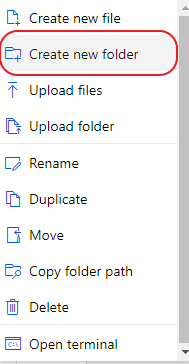

In [32]:
display.Image("Image/Image1.2.png")

**Step2: General imports**

In [40]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential
credential = DefaultAzureCredential()
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import Input, Output
from azure.ai.ml import command

**Step3: Upload the data file ("brain_stroke_processed_v2.csv) extracted from brain_stroke_pre_processing notebook**

Let's explore the process of registering an external dataset as a data asset in the Azure ML environment. In this scenario, we will copy a local dataset to Azure blob storage and then proceed to register the file as a data asset.

In [37]:
local_data_path = 'data/brain_stroke_processed_v2.csv'

In [42]:
data_asset = Data(
    path=local_data_path,
    type=AssetTypes.URI_FILE,
    description="A dataset of brain stroke analysis",
    name="brain_stroke_processed",
    version="3"
)

In [43]:
ml_client.data.create_or_update(data_asset)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'brain_stroke_processed', 'description': 'A dataset of brain stroke analysis', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/1c6d9ef7-1867-436f-986f-f37c475a295b/resourceGroups/testml/providers/Microsoft.MachineLearningServices/workspaces/azureml/data/brain_stroke_processed/versions/3', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/checklab/code/Users/TESTXRC71JBY4S_1686047967735/mls3', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fb90cd3c5e0>, 'serialize': <msrest.serialization.Serializer object at 0x7fb90cd3ca90>, 'version': '3', 'latest_version': None, 'path': 'azureml://subscriptions/1c6d9ef7-1867-436f-986f-f37c475a295b/resourcegroups/testml/workspaces/azureml/datastores/workspac

Once the data asset is registered, it can be accessed and inspected as described in the previous section.

In [44]:
for registered_data in ml_client.data.list():
    print(registered_data.name)

check
airbnb_data
car_mpg_jun
advertising
diamond-prices-jan
diamond-prices-may
brain_stroke_processed


**Step4: Provide workspace details**

**Note: Select the subscription on the top right to see the credential information.**

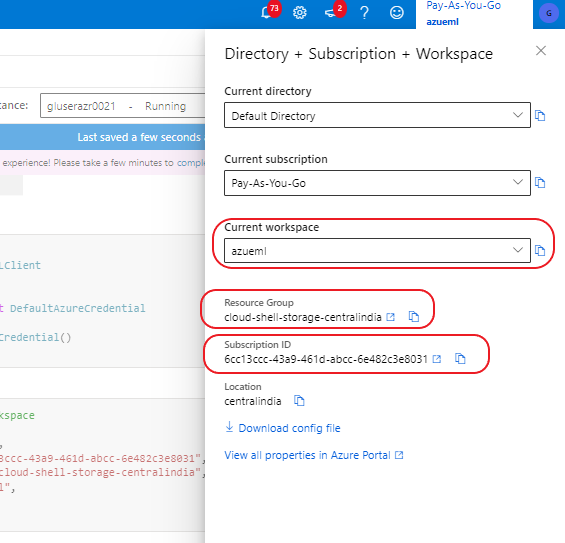

In [14]:
display.Image("Image/Image3.png")

In [45]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="1c6d9ef7-1867-436f-986f-f37c475a295b",
    resource_group_name="testml",
    workspace_name="azureml",
)

In [46]:
# Get the workspace
from azureml.core import Workspace

ws = Workspace(subscription_id="1c6d9ef7-1867-436f-986f-f37c475a295b",
                resource_group="testml",
                workspace_name="azureml")
print('Ready to work with', ws.name)

Ready to work with azureml


**Step:4 Write down the processing script "pre_process.py" which will define the code to be executed for the processing job **

Steps performed for data processing are as follows:

* Import the necessary libraries

* Set up command-line arguments using argparse. The script expects two arguments: --data for the path to the input data and --output for the path to the output data.

* Parse the command-line arguments using argparse.

* Prepare the data:

* Read the input data from the specified path using pd.read_csv.

* Data Cleaning:

1. Define the target column and the numeric features.

2. Separate the input features (X) and the target variable (y) from the dataset.

3. Split the data into training and testing sets using train_test_split.

* Prepare the data:

1. Create a column transformer using make_column_transformer to apply a scaler (StandardScaler) to the numeric features.

2. Apply the column transformer to the training and testing sets to transform the numeric features.

* Define the output data store path.

* Define the paths for the output files: training features, training labels, testing features, and testing labels.

* Save the transformed training features to a CSV file using pd.DataFrame.to_csv.

* Save the transformed testing features to a CSV file.

* Save the training labels to a CSV file.

* Save the testing labels to a CSV file.

In [47]:
import os

train_src_dir = "./azure"
os.makedirs(train_src_dir, exist_ok=True)

In [48]:
%%writefile {train_src_dir}/pre_process.py

import argparse
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--output", type=str, help="path to output data")
    args = parser.parse_args()
   

    ###################
    #<prepare the data>
    ###################
 
    # Read the input data from the specified path
    df = pd.read_csv(args.data)


    ###################
    #<Data Cleaning>
    ###################

    # Define the target column and the numeric features

    target = 'stroke'
    numeric_features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'smoking_status', 'is_paralyzed',
       'avg_glucose_level', 'bmi']
    
    # Separate the input features (X) and the target variable (y)

    X = df.drop(columns=[target])
    y = df[target]

    # Split the data into training and testing sets
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

    # Define a column transformer to scale the numeric features
    preprocessor = make_column_transformer(
        (StandardScaler(), numeric_features)
    )
    
    # Apply the column transformer to the training and testing sets
    transformed_Xtrain = preprocessor.fit_transform(Xtrain)
    transformed_Xtest = preprocessor.transform(Xtest)
    
    # Define the output data store path
    output_data_store = args.output

    # Define the paths for the output files
    train_features_output_path = Path(output_data_store, "train_features.csv")
    train_labels_output_path = Path(output_data_store, "train_labels.csv")
    
    test_features_output_path = Path(output_data_store, "test_features.csv")
    test_labels_output_path = Path(output_data_store, "test_labels.csv")

    # Save the transformed training features to a CSV file
    pd.DataFrame(transformed_Xtrain).to_csv(train_features_output_path, index=False)
    # Save the transformed testing features to a CSV file
    pd.DataFrame(transformed_Xtest).to_csv(test_features_output_path, index=False)

    # Save the training labels to a CSV file
    ytrain.to_csv(train_labels_output_path, index=False)
    # Save the testing labels to a CSV file
    ytest.to_csv(test_labels_output_path, index=False)

Overwriting ./azure/pre_process.py


**Step:5 Configure the command**

Here, we'll create input variables to specify the input data, split ratio and output data. The command script will:
* Use the compute cluster to run the command.
* Use an environment that defines software and runtime libraries needed for the processing script.
* Configure the command line action itself - python pre_process.py in this case. The inputs/outputs are accessible in the command via the ${{ ... }} notation.
* In this sample, we access the data from a file present in the local machine and store the processed data in the Datastores.

In [49]:
datastore_path = "azureml://datastores/workspaceblobstore/paths/training-data/"

In [51]:
my_job_inputs = {
    "input_data": Input(type=AssetTypes.URI_FILE, 
                        path="azureml:brain_stroke_processed:3")
}

my_job_outputs = {
    "output_datastore": Output(type=AssetTypes.URI_FOLDER,
                               path=datastore_path)
}

In [52]:
job = command(
    code="./azure",  # location of source code
    command="python pre_process.py --data ${{inputs.input_data}} --output ${{outputs.output_datastore}}",
    inputs= my_job_inputs,
    outputs=my_job_outputs,
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    compute="checklab",
    experiment_name="brain_stroke_preprocessing",
    display_name="brain_stroke"
)

**Step:6 Submit the job**

In [53]:
ml_client.create_or_update(job)

Uploading azure (0.0 MBs): 100%|██████████| 4819/4819 [00:00<00:00, 40337.65it/s]




Experiment,Name,Type,Status,Details Page
brain_stroke_preprocessing,zen_apricot_tg2yk7kk1d,command,Starting,Link to Azure Machine Learning studio


**Note1: We can check the status of the Job by going to the "Jobs" on the left.**

**Note2: We can check the stored output data by directing towards the datastores from the left panel.**

______________________________________________________________________________________